In [ ]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
import pickle
import os
import pickle
from sampler import sample
from utils_vMQP import *
from wind_plots import *
import matplotlib.pyplot as plt

pi = np.pi 

data = pd.read_csv("data_calm.csv")

seed = 18
np.random.seed(seed)

# Split data into train and test
prec = 0.2 # Proportion of test data
data_shape = data.shape[0]
test_size = int(prec * data_shape)
test_ind = np.random.choice(data_shape, size=test_size, replace=False)
train_ind = np.setdiff1d(np.arange(data_shape), test_ind)
ind_un = test_ind
ind_obs = train_ind    


# Create necessary arrays for further use
combined_xs = data[['Longitude', 'Latitude']].values # All locations
xs = combined_xs[ind_obs,:] # Train locations
pred_xs = combined_xs[ind_un,:] # Test locations

ys_all = data['dir'].values # All observed values
ys = ys_all[ind_obs] # Train observed
test_ys = ys_all[ind_un] # Test observed

d = combined_xs.shape[0] # Number of locations overall
du = test_ys.shape[0] # Number of test locations

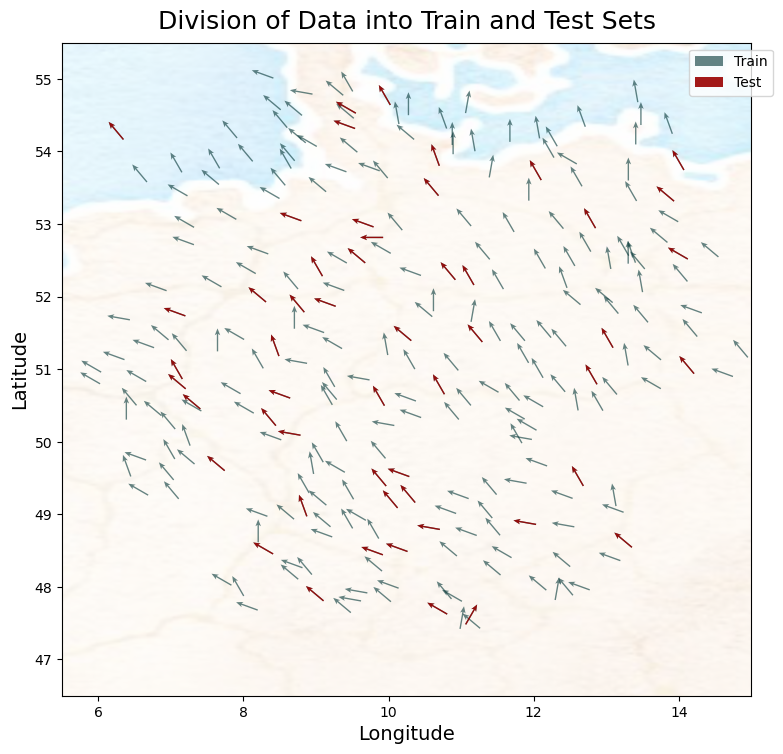

In [55]:
# Plot train-test split
fig, ax = plot_train_test_split(combined_xs, ys_all, ind_obs, ind_un)
plt.show()

In [13]:
#########################
# Initialize parameters #
#########################

Nsamples = 100000
samples = np.zeros([d, Nsamples])
i0 = 10000
i=None
samples=None

In [ ]:
############
# Run MCMC # 
############
# Note that you can stop the execution and continue later by running this cell again

# Set up directory for saving samples
samples_dir = './samples_calm/'
os.makedirs(samples_dir, exist_ok=True)


@dataclass
class MCMC_Parameters:
    sigma2_l1: float = 1
    sigma2_l2: float = 1
    sigma2_kappa: float = 1

    sigma_prop_l1: float = 0.2
    sigma_prop_l2: float = 0.01
    sigma_prop_kappa: float = 0.2
    sigma_prop_nu: float = 0.1

    N_thetap: int = 100
    discard: int = 0
    N_theta: int = 300
    tqdm_disable: bool = True

    l10: float = 0.5
    l20: float = 0.3
    bridging: bool = True
    K: int = 2
    Geweke: bool = False



# Initialize MCMC parameters
pars = MCMC_Parameters()

# Run MCMC
samples, i, acc = sample(Nsamples, pars, combined_xs, ind_obs, ys, i=i, samples=samples, kernel = "exp")

# save samples
samples_filename = f'{samples_dir}/samples_wind.pkl'
with open(samples_filename, 'wb') as f:
    pickle.dump(samples, f, pickle.HIGHEST_PROTOCOL)

# save parameters
par_filename = f'{samples_dir}/params_wind.pkl'
with open(par_filename, 'wb') as f:
    pickle.dump(pars, f, pickle.HIGHEST_PROTOCOL)




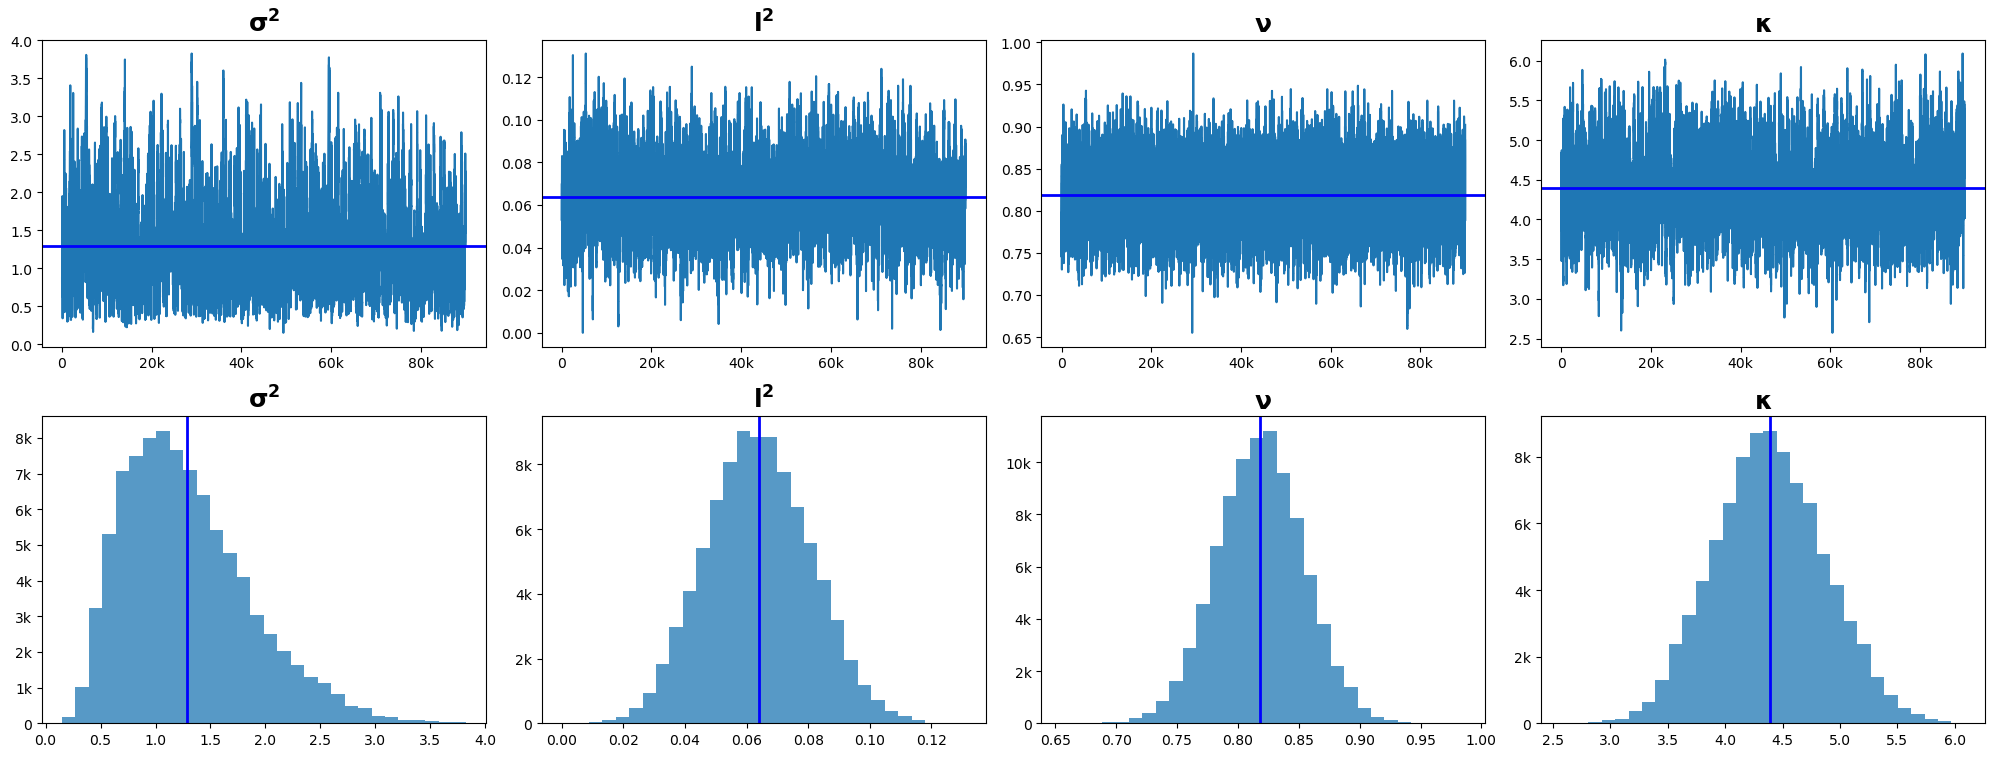

In [19]:
# parameter traces and histograms
fig, axs = plot_parameter_traces(samples, i, 
                                     N_burnin_trace=i0, 
                                     N_burnin_hist=i0)

In [ ]:
##########################
# Code to upload samples #
##########################

# Set up directory of samples
samples_dir = "samples_calm"
file_name = "samples_wind" # Change this to the name of the file you want to load
samples_filename = f'{samples_dir}/{file_name}.pkl'

# Load samples
with open(samples_filename, 'rb') as f:
    samples = pickle.load(f)


C:\Users\97252\AppData\Local\Temp\ipykernel_32576\73448593.py:12: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  samples = pickle.load(f)


(<Figure size 1000x1500 with 1 Axes>,
 <Axes: xlabel='Longitude', ylabel='Latitude'>)

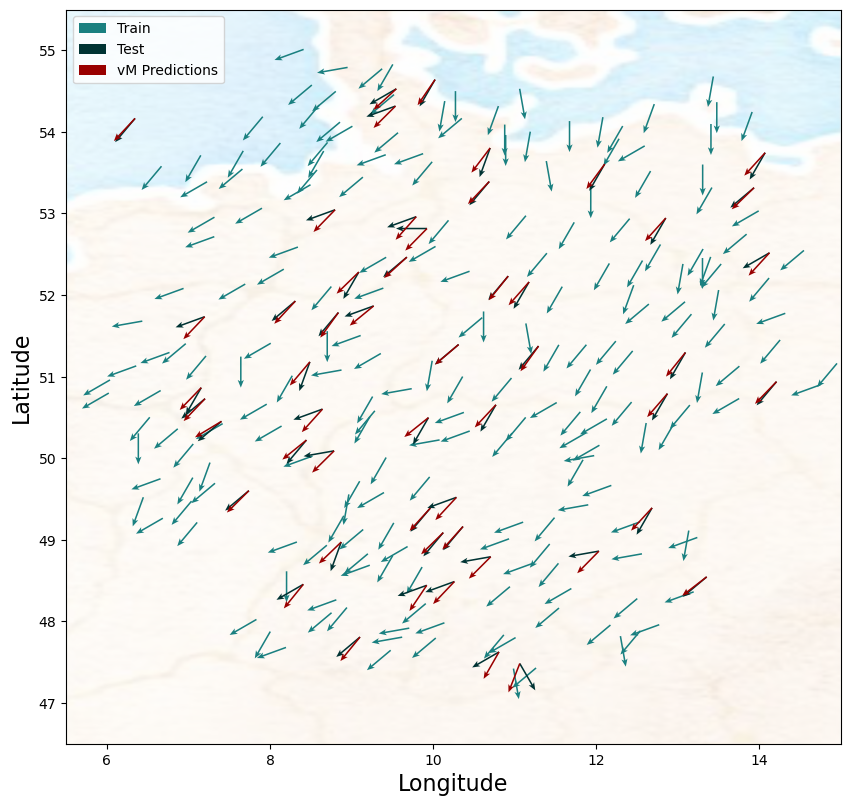

In [20]:
# Plot wind predictions
plot_wind_directions(combined_xs, ys_all, ind_obs, ind_un, samples.angles[ind_un,i0:i].T)

In [21]:
##########################
# Code to calculate CRPS #
##########################
# using the implementations of the CircSpaceTime R package (Jona Lasinio et al., 2020).
# Download the R package from https://cran.r-project.org/web/packages/CircSpaceTime/index.html

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
from rpy2.robjects import pandas2ri, r, numpy2ri

pandas2ri.activate()
numpy2ri.activate()

# Read and load  R libraries
r_library = r['library']
r_libraries = ['CircSpaceTime']

for lib in r_libraries:
    r_library(lib)

# Extract predictions
testPredVonMises = samples.angles[ind_un, i0 : i].T
# Extract every 10th row (to speed up CRPS calculation)
testPredVonMises_10th_row = testPredVonMises[::5].T 

# Reshape test_ys for CRPS calculation
tYs = test_ys.transpose()
tYsT = tYs.transpose().reshape((tYs.shape[0], 1))
tYsT_r = r['c'](tYsT.flatten())

# Calculate CRPS using CircSpaceTime R function
resultVM = r['CRPScirc'](tYsT_r, testPredVonMises_10th_row, bycol=False)

# Extract metrics
mean_crps = float(resultVM.rx2('CRPS')[0])  # Convert R object to Python float
max_crps = float(np.max(resultVM.rx2('CRPSvec')))

print(f"Mean CRPS: {mean_crps}")
print(f"Max CRPS: {max_crps}")


Mean CRPS: 0.05872254314055133
Max CRPS: 0.36444093342747536


c:\Users\97252\Desktop\vMQP_final\vMQP\vis.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(label, fontsize=fontsize)
c:\Users\97252\Desktop\vMQP_final\vMQP\vis.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(label, fontsize=fontsize)
c:\Users\97252\Desktop\vMQP_final\vMQP\vis.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(label, fontsize=fontsize)
c:\Users\97252\Desktop\vMQP_final\vMQP\vis.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(label, fontsize=fontsize)


(<Figure size 1600x700 with 12 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

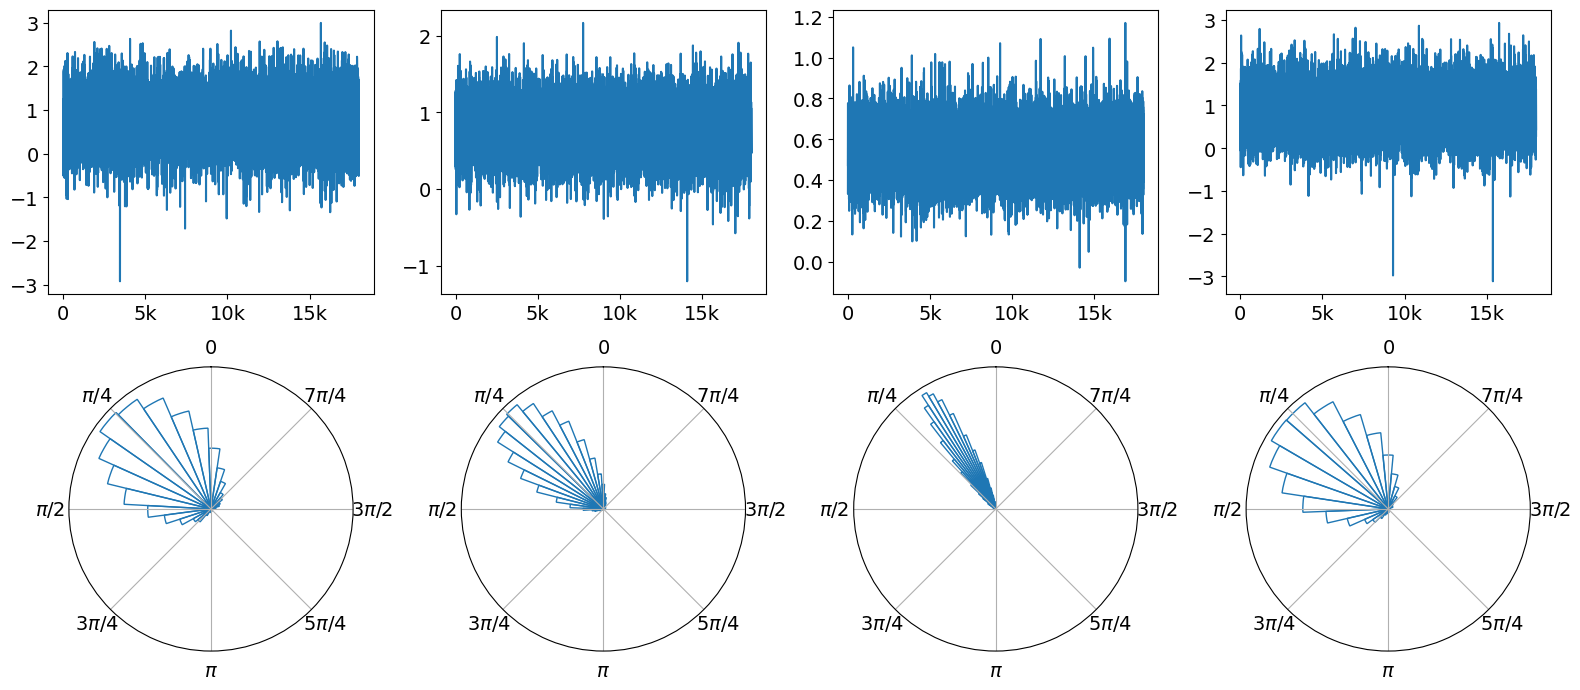

In [22]:
plot_selected_predictions(testPredVonMises_10th_row, column_indices=[4, 17, 30, 43], bins=32)